# Exercise 1: Weather Forecast

In [182]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from statsmodels.tsa.api import VECM
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import joblib

In [9]:
def null_percentage(data):
    """It calculates the percentage of null values"""
    total_null_perc = {}
    total_size = data.shape[0]
    for i in list(data):
        null_count = data[i].isnull().sum()
        null_perc = {i:round(((null_count)/total_size)*100,1)}
        total_null_perc.update(null_perc)
    total_null_percentage = dict(sorted(total_null_perc.items(), key=lambda item: item[1], reverse=True))
    return total_null_percentage

def adf_test(series):
    result = adfuller(series.dropna())
    return result[1] < 0.05  

def data_plot(data_set,time_stamp):
    """ It plots all the columns """
    cols_to_plot = [col for col in data_set.columns if data_set[col].dtype in ['int64', 'float64']]
    fig, axes = plt.subplots(len(cols_to_plot), 1, figsize=(12, 3 * len(cols_to_plot)))
    for i, col in enumerate(cols_to_plot):
        data_set[[col]].plot(ax=axes[i]) 
        axes[i].set_ylabel(col) 
    plt.tight_layout()
    plt.show()
    del data_set

def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    return mae, rmse

In [11]:
dataset_path = "spark_renewable_ds_forecast_challenge.csv"
time_stamp ='TimeStamp (UTC)'

In [13]:
data = pd.read_csv(dataset_path)
display(data.tail())

,TimeStamp (UTC),WindDirection Avg,WindSpeed Avg,WindSpeed StdDev,T AMB Avg,In AirDensity Avg
8755,2022-01-01 01:00:00+00:00,208.104834,7.773756,1.063713,14.583112,1.082299
8756,2022-01-01 02:00:00+00:00,207.913343,5.461555,0.755680,13.885774,1.085138
8757,2022-01-01 03:00:00+00:00,203.262241,4.124327,0.752599,13.563728,1.086148
8758,2022-01-01 04:00:00+00:00,190.455956,1.994891,0.816381,13.751722,1.085652
8759,2022-01-01 05:00:00+00:00,187.412232,4.344308,0.726658,13.933904,1.085285


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TimeStamp (UTC)    8760 non-null   object 
 1   WindDirection Avg  6568 non-null   float64
 2   WindSpeed Avg      8740 non-null   float64
 3   WindSpeed StdDev   8625 non-null   float64
 4   T AMB Avg          8740 non-null   float64
 5   In AirDensity Avg  8469 non-null   float64
dtypes: float64(5), object(1)
memory usage: 410.8+ KB


In [17]:
total_null_perc = null_percentage(data)
print('Total Null Percentages')
total_null_perc

Total Null Percentages


{'WindDirection Avg': 25.0,
 'In AirDensity Avg': 3.3,
 'WindSpeed StdDev': 1.5,
 'WindSpeed Avg': 0.2,
 'T AMB Avg': 0.2,
 'TimeStamp (UTC)': 0.0}

    Key Observations:

    - The dataset has 8760 entries, representing an hourly timeseries for one year.
    - Columns such as wind speed and temperature have relatively few missing values.
    - Wind direction and air density have more significant gaps.
    - The target variable for forecasting is likely WindSpeed Avg.


In [20]:
data[time_stamp] = pd.to_datetime(data[time_stamp])
data.set_index(time_stamp, inplace=True)

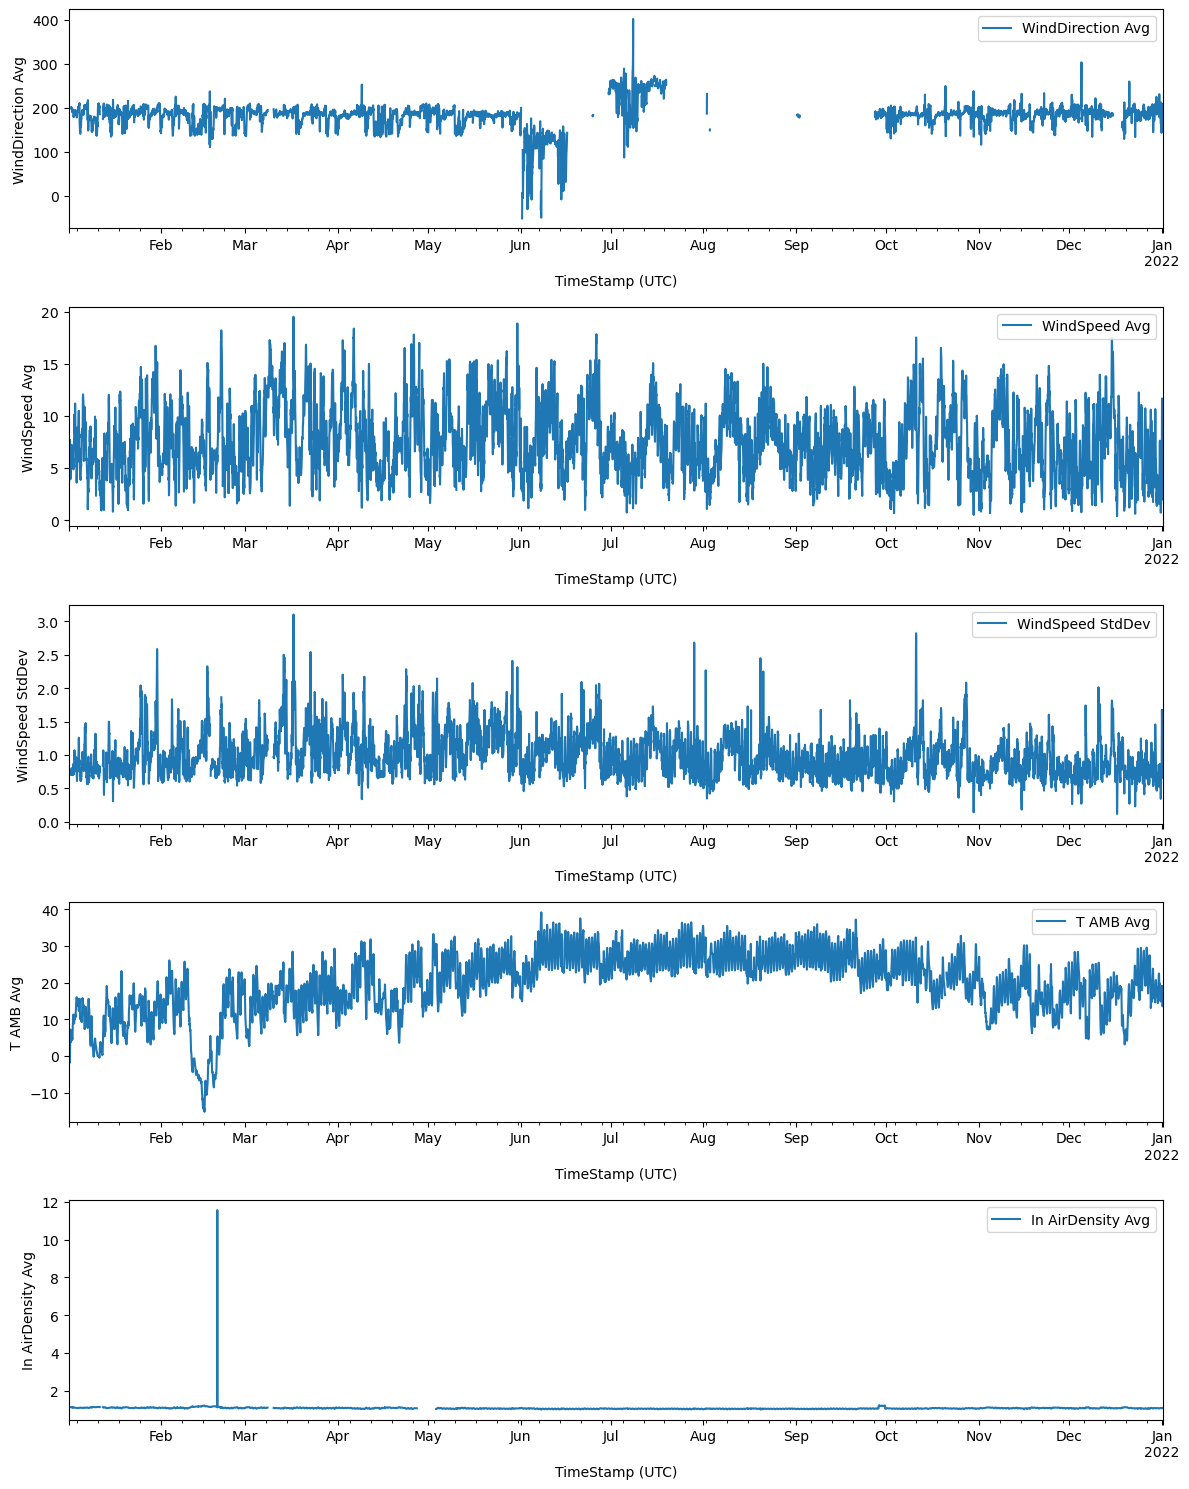

In [22]:
data_plot(data,time_stamp)

In [23]:
data = data.sort_values(by=time_stamp, ascending=True)

display(data)

,WindDirection Avg,WindSpeed Avg,WindSpeed StdDev,T AMB Avg,In AirDensity Avg
TimeStamp (UTC),,,,,
2021-01-01 06:00:00+00:00,NaN,5.110103,NaN,-0.896897,NaN
2021-01-01 07:00:00+00:00,NaN,5.221429,NaN,-0.847589,NaN
2021-01-01 08:00:00+00:00,NaN,5.411667,NaN,-1.000000,NaN
2021-01-01 09:00:00+00:00,NaN,4.855000,NaN,-1.000000,NaN
2021-01-01 10:00:00+00:00,NaN,4.369630,NaN,-0.398102,NaN
...,...,...,...,...,...
2022-01-01 01:00:00+00:00,208.104834,7.773756,1.063713,14.583112,1.082299
2022-01-01 02:00:00+00:00,207.913343,5.461555,0.755680,13.885774,1.085138
2022-01-01 03:00:00+00:00,203.262241,4.124327,0.752599,13.563728,1.086148


# Data Preparation

In [24]:
data.interpolate(method='linear', inplace=True)

In [28]:
data.isnull().sum()

WindDirection Avg    19
WindSpeed Avg         0
WindSpeed StdDev     19
T AMB Avg             0
In AirDensity Avg    19
dtype: int64

In [30]:
data[data.isnull().any(axis=1)]

,WindDirection Avg,WindSpeed Avg,WindSpeed StdDev,T AMB Avg,In AirDensity Avg
TimeStamp (UTC),,,,,
2021-01-01 06:00:00+00:00,NaN,5.110103,NaN,-0.896897,NaN
2021-01-01 07:00:00+00:00,NaN,5.221429,NaN,-0.847589,NaN
2021-01-01 08:00:00+00:00,NaN,5.411667,NaN,-1.000000,NaN
2021-01-01 09:00:00+00:00,NaN,4.855000,NaN,-1.000000,NaN
2021-01-01 10:00:00+00:00,NaN,4.369630,NaN,-0.398102,NaN
2021-01-01 11:00:00+00:00,NaN,4.609144,NaN,-0.598333,NaN
2021-01-01 12:00:00+00:00,NaN,5.981667,NaN,-1.010000,NaN
2021-01-01 13:00:00+00:00,NaN,7.025000,NaN,-1.936667,NaN
2021-01-01 14:00:00+00:00,NaN,6.674769,NaN,-0.046065,NaN


    Key Observations:

    - After interpolation first 19 hours data is empty for 
    - WindDirection Avg,
    - WindSpeed StdDev,
    - In AirDensity Avg.

In [33]:
data.dropna(axis=0,inplace=True)

In [35]:
total_null_perc = null_percentage(data)
print('Total Null Percentages')
total_null_perc

Total Null Percentages


{'WindDirection Avg': 0.0,
 'WindSpeed Avg': 0.0,
 'WindSpeed StdDev': 0.0,
 'T AMB Avg': 0.0,
 'In AirDensity Avg': 0.0}

In [37]:
max(data.index)-min(data.index)

Timedelta('364 days 04:00:00')

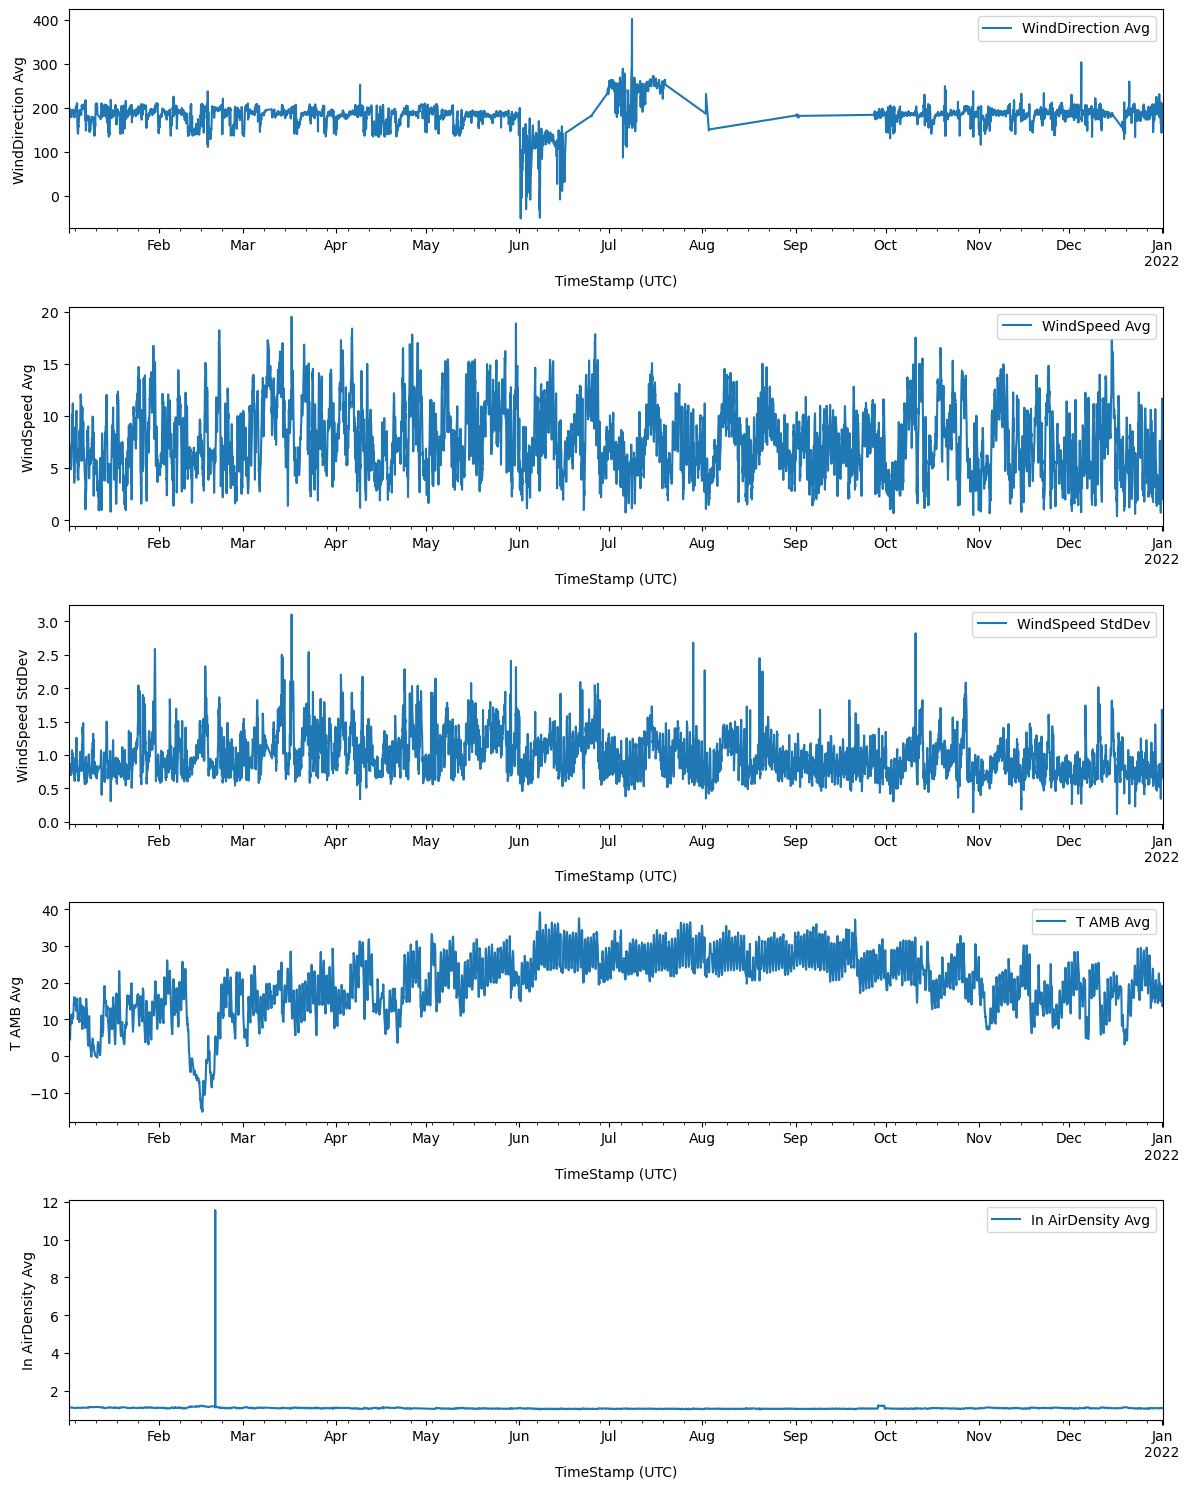

In [39]:
data_plot(data,time_stamp)

# Stationarity Check

In [42]:

johansen_test = coint_johansen(data, det_order=0, k_ar_diff=1)
trace_stat = johansen_test.lr1  
critical_values = johansen_test.cvt
print("Eigenvalues:", johansen_test.eig)
print("Trace Statistics:", trace_stat)
print("Critical Values (90%, 95%, 99%):", critical_values)

Eigenvalues: [0.32548894 0.13283591 0.04651812 0.02712308 0.01334705]
Trace Statistics: [5460.68429203 2019.55268484  774.00875196  357.72769184  117.42529966]
Critical Values (90%, 95%, 99%): [[65.8202 69.8189 77.8202]
 [44.4929 47.8545 54.6815]
 [27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


    Conclusion:
       All 5 variables (WindDirection Avg, WindSpeed Avg, WindSpeed StdDev, T AMB Avg, In AirDensity Avg) are cointegrated, indicating a stable, long-term equilibrium relationship among them.


In [45]:
for column in data.columns:
    if not adf_test(data[column]):
        print(f"{column} is non-stationary ")
    else:
        print(f"{column} is stationary")

WindDirection Avg is stationary
WindSpeed Avg is stationary
WindSpeed StdDev is stationary
T AMB Avg is stationary
In AirDensity Avg is stationary


# Modelling

In [46]:
train = data.iloc[:-48]
test = data.iloc[-48:]
initial_values = data.iloc[-49:-48].values
vecm = VECM(train, k_ar_diff=1, coint_rank=5) 
vecm_fitted = vecm.fit()

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


# Forecast

In [49]:

forecast = vecm_fitted.predict(steps=48)
forecast_df = pd.DataFrame(forecast, index=test.index, columns=test.columns)
forecast_original_scale = forecast_df.cumsum() + data.iloc[-49:-48].values
persistence_forecast = pd.DataFrame([data.iloc[-1].values] * 48, index=test.index, columns=test.columns)

# Error metric

In [51]:


vecm_mae, vecm_rmse = evaluate_model(test['WindSpeed Avg'], forecast_original_scale['WindSpeed Avg'])
print(f"VECM Model MAE: {vecm_mae}, RMSE: {vecm_rmse}")

persistence_mae, persistence_rmse = evaluate_model(test['WindSpeed Avg'], persistence_forecast['WindSpeed Avg'])
print(f"Persistence Model MAE: {persistence_mae}, RMSE: {persistence_rmse}")


VECM Model MAE: 120.69818154993561, RMSE: 146.80181445721806
Persistence Model MAE: 1.9453232592708332, RMSE: 2.47604936670656


# Plot actual vs forecasted for VECM and Persistence

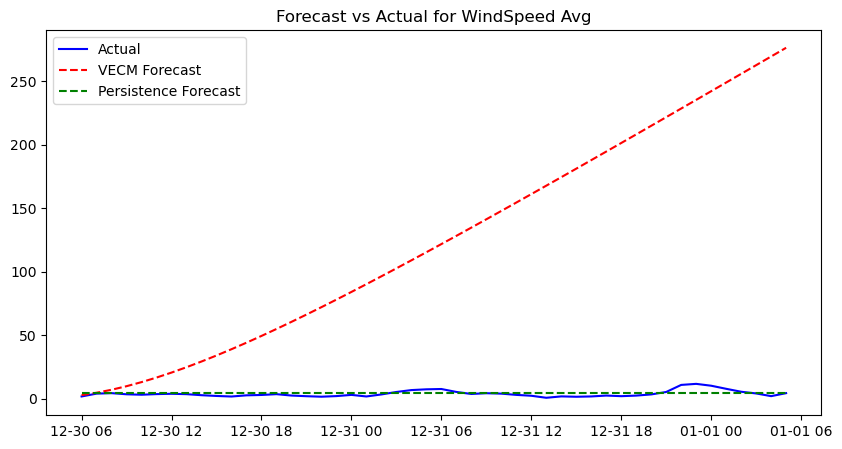

In [53]:

column = 'WindSpeed Avg'
plt.figure(figsize=(10, 5))
plt.plot(test[column], label="Actual", color='blue')
plt.plot(forecast_original_scale[column], label="VECM Forecast", linestyle='dashed', color='red')
plt.plot(persistence_forecast[column], label="Persistence Forecast", linestyle='dashed', color='green')
plt.title(f"Forecast vs Actual for {column}")
plt.legend()
plt.show()


# Exercise 2: Anomaly Detection

In [188]:
path = "anomaly_detection.csv"

In [190]:
df = pd.read_csv(path)

In [192]:
display(df.head())

,CEACC,CCDEF,FAXAE,FBFFD,EDDAB
0,0.000000,0.000000,3.000000,3.000000,8.000000
1,1.232260,-0.217305,3.193780,3.489992,7.792553
2,2.540129,0.606709,3.180950,3.464811,7.817440
3,5.520271,1.470812,3.330528,2.968375,7.409152
4,5.914298,2.745060,3.061706,3.440980,7.153049


In [194]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CEACC   365 non-null    float64
 1   CCDEF   365 non-null    float64
 2   FAXAE   365 non-null    float64
 3   FBFFD   365 non-null    float64
 4   EDDAB   365 non-null    float64
dtypes: float64(5)
memory usage: 14.4 KB


In [196]:
df['DATE'] =pd.date_range(start='2016-01-01', end='2016-12-30')

In [199]:
df.set_index("DATE", inplace=True)

In [201]:
training_data = df.loc['01/01/2016':'09/30/2016']  
testing_data = df.loc['10/01/2016':'12/30/2016']  

# Data Scaling

In [203]:
scaler = StandardScaler()
training_scaled = scaler.fit_transform(training_data)
testing_scaled = scaler.transform(testing_data)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

<Axes: xlabel='DATE'>

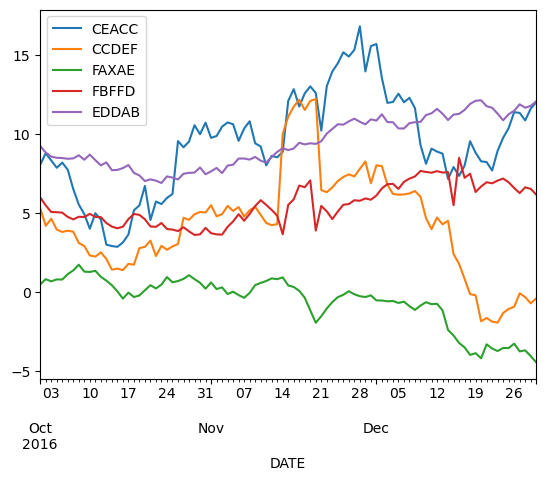

In [207]:
testing_data.plot()

# Model Training

In [209]:
model = IsolationForest(contamination=0.01, random_state=42)  
model.fit(training_scaled)
joblib.dump(model, 'isolation_forest_model.pkl')

['isolation_forest_model.pkl']

# Anomaly Detection

In [211]:
testing_predictions = model.predict(testing_scaled)
testing_data['Anomaly'] = testing_predictions

/var/folders/mc/gfc07gh15flgdyr91tcw83qm0000gn/T/ipykernel_42317/2846643059.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data['Anomaly'] = testing_predictions


In [385]:
testing_data['Anomaly_Group'] = (testing_data['Anomaly'] == -1).astype(int).diff().ne(0).cumsum()
anomalous_periods = testing_data[testing_data['Anomaly'] == -1].groupby('Anomaly_Group').size()



/var/folders/mc/gfc07gh15flgdyr91tcw83qm0000gn/T/ipykernel_42317/3220991813.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data['Anomaly_Group'] = (testing_data['Anomaly'] == -1).astype(int).diff().ne(0).cumsum()


In [215]:
testing_data

,CEACC,CCDEF,FAXAE,FBFFD,EDDAB,Anomaly,Anomaly_Group
DATE,,,,,,,
2016-10-01,8.046032,5.295155,0.490067,5.972950,9.221123,1,1
2016-10-02,8.769270,4.184700,0.815883,5.476941,8.813725,1,1
2016-10-03,8.311614,4.632987,0.679195,5.056123,8.552767,1,1
2016-10-04,7.850020,3.950758,0.800483,5.045620,8.481428,1,1
2016-10-05,8.176031,3.795881,0.791072,5.016191,8.465436,1,1
...,...,...,...,...,...,...,...
2016-12-26,11.364339,-0.925751,-3.259216,6.572904,11.452315,-1,8
2016-12-27,11.316572,-0.081164,-3.746738,6.252706,11.859704,-1,8
2016-12-28,10.841367,-0.317127,-3.680397,6.617491,11.644486,-1,8


# Report Generation

In [393]:
def report(testing_data,anomalous_periods):
    valid_anomalies = anomalous_periods[(anomalous_periods > 2) & (anomalous_periods <= 14)]
    
    if valid_anomalies.index.to_list():
        valid_anomalous_time_ranges = []
        for group in valid_anomalies.index:
            anomaly_group_data = testing_data[testing_data['Anomaly_Group'] == group]
            start_date = anomaly_group_data.index.min()  
            end_date = anomaly_group_data.index.max()    
            valid_anomalous_time_ranges.append((start_date, end_date))
        anomalous_periods = pd.DataFrame(valid_anomalous_time_ranges,columns=['start','end'])
    else:
        anomalous_periods = pd.DataFrame()
    return anomalous_periods



In [395]:
report(testing_data,anomalous_periods)

,start,end
0,2016-11-17,2016-11-20
1,2016-12-02,2016-12-04
2,2016-12-06,2016-12-14


# Exercise 3: Model Deployment

# API Development

In [ ]:
from flask import Flask, request, jsonify
import pandas as pd
import joblib

model = joblib.load('isolation_forest_model.pkl')
scaler = joblib.load('scaler.pkl')

app = Flask(__name__)


def report(testing_data, anomalous_periods):
    valid_anomalies = anomalous_periods[(anomalous_periods > 2) & (anomalous_periods <= 14)]

    if valid_anomalies.index.to_list():
        valid_anomalous_time_ranges = []
        for group in valid_anomalies.index:
            anomaly_group_data = testing_data[testing_data['Anomaly_Group'] == group]
            start_date = anomaly_group_data.index.min()
            end_date = anomaly_group_data.index.max()
            valid_anomalous_time_ranges.append((start_date, end_date))
        anomalous_periods = pd.DataFrame(valid_anomalous_time_ranges, columns=['start', 'end'])
    else:
        anomalous_periods = pd.DataFrame()
    return anomalous_periods

@app.route('/predict', methods=['POST'])
def predict_anomalies():
    input_data = request.get_json()
    test_data = pd.DataFrame(input_data['data'])
    test_data_scaled = scaler.transform(test_data)
    predictions = model.predict(test_data_scaled)
    test_data['Anomaly'] = predictions
    test_data['Date'] = pd.date_range(start=input_data['start_date'], periods=len(test_data))
    test_data.set_index("Date", inplace=True)
    test_data['Anomaly_Group'] = (test_data['Anomaly'] == -1).astype(int).diff().ne(0).cumsum()
    anomaly_groups = test_data[test_data['Anomaly'] == -1].groupby('Anomaly_Group').size()
    details = report(test_data, anomaly_groups)
    result = {
        "number_of_anomalous_periods": details.shape[0],
        "details": details.to_dict()
    }

    return jsonify(result)

if __name__ == '__main__':
    app.run(debug=True)


# API Testing

In [415]:
import requests
import json


url = "http://127.0.0.1:5000/predict"


test_data = {
    "start_date": "2016-10-01",
    "data": [
        {"CEACC": 0.5, "CCDEF": -0.2, "FAXAE": 1.1,"FBFFD":2.0,"EDDAB":-1},
        {"CEACC": 0.6, "CCDEF": -0.1, "FAXAE": 1.0,"FBFFD":2.0,"EDDAB":-1},
        {"CEACC": 0.8, "CCDEF": -0.3, "FAXAE": 1.2,"FBFFD":2.0,"EDDAB":-1},
        {"CEACC": 0.2, "CCDEF": -0.6, "FAXAE": 1.5,"FBFFD":2.0,"EDDAB":-1},
        {"CEACC": 0.9, "CCDEF": -0.4, "FAXAE": 1.3,"FBFFD":2.0,"EDDAB":-1}]
    
}

headers = {"Content-Type": "application/json"}
response = requests.post(url, data=json.dumps(test_data), headers=headers)


if response.status_code == 200:
    print("API Response:")
    print(response.json())
else:
    print(f"Error: {response.status_code}")
    print(response.text)

API Response:
{'details': {'end': {'0': 'Wed, 05 Oct 2016 00:00:00 GMT'}, 'start': {'0': 'Sat, 01 Oct 2016 00:00:00 GMT'}}, 'number_of_anomalous_periods': 1}


In [411]:
pd.DataFrame(response.json()['details'])

,end,start
0,"Wed, 05 Oct 2016 00:00:00 GMT","Sat, 01 Oct 2016 00:00:00 GMT"
